# The Morris-Lecar model

Like the Fitzhugh-Nagumo model, the Morris-Lecar model is a reduced version of the HH model. It is described by the following set of ODEs:

$
C_m \dot{V_m} = -g_L(V_m-E_L) - \bar{g}_{Ca} M_{\infty}(V_m)(V_m-E_{Ca}) - \bar{g}_K n(V_m-E_K) + I_{ext}\\
\dot{n} = \frac{n_\infty(V_m) - n}{\tau_n(V_m)} \\
$

where the functions $M_\infty(V_m)$, $n_\infty(V_m)$ and $\tau_n(V_m)$ are given by

$
M_\infty(V_m) = \frac{1}{2}\left(1 + \tanh\left(\frac{V_m-V_1}{V_2}\right)\right) \\
n_\infty(V_m) = \frac{1}{2}\left(1 + \tanh\left(\frac{V_m-V_3}{V_4}\right)\right) \\
\tau_n(V_m) = \frac{\tau_0}{\cosh\left(\frac{V_m-V_3}{2V_4}\right)}
$

Unless otherwise noted, the constant parameters used in the following are taken from [this paper](https://doi.org/10.1016/j.neucom.2005.03.006): <br/>
Tsumoto, K., Kitajima, H., Yoshinaga, T., Aihara, K. and Kawakami, H., 2006. _Bifurcations in Morris–Lecar neuron model_. Neurocomputing, 69(4-6), pp.293-316.

The purpose of this notebook is to show how a saddle-node bifurcation leads to stable oscillations (i.e., spiking) in the model, and how these are terminated by a (subcritical) Hopf bifurcation.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
C = 20
gCa,gK,gL = 4,8,2
ECa,EK,EL = 120,-80,-60
V1,V2 = -1.2,18
V3,V4 = 12,17.4
tau0 = 15

def Mss(x):
    return 0.5 * (1+np.tanh((x-V1)/V2))

def nss(x):
    return 0.5 * (1+np.tanh((x-V3)/V4))

def taun(x):
    return tau0 / np.cosh((x-V3)/(2*V4))

def ML(t,x,I):
    V,n = x
    return np.array([
        (-gCa*Mss(V)*(V-ECa) - gK*n*(V-EK) - gL*(V-EL) + I)/C,
        (nss(V)-n)/taun(V)
    ])

def ML_jac(t,x,I):
    sech = lambda z: 1/np.cosh(z)
    V,n = x
    J = np.zeros((2,2), dtype=float)
    x = (V-V1)/V2
    J[0,0] = (-0.5*gCa*(np.tanh(x)+1)-(0.5*gCa*(V-ECa)*sech(x)**2)/V2-gK*n-gL)/C
    J[0,1] = -gK*(V-EK)/C
    x = (V-V3)/V4
    J[1,0] = (np.sinh(x/2)*(0.25*np.tanh(x)-0.5*n+0.25)+0.5*np.cosh(x/2)*sech(x)**2)/(tau0*V4)
    J[1,1] = -np.cosh(x/2)/tau0
    return J

def V_nullcline(V,I):
    return (-gCa*Mss(V)*(V-ECa) - gL*(V-EL) + I) / (gK*(V-EK))

n_nullcline = nss

In [3]:
def find_roots(f, a, b, steps, args=()):
    from scipy.optimize import bisect
    x = np.linspace(a,b,steps)
    xa,ya = x[0],f(x[0],*args)
    roots = []
    for i in range(1, steps):
        xb,yb = x[i], f(x[i],*args)
        if ya*yb < 0:
            xr = bisect(f, xa, xb, args=args)
            yr = f(xr,*args)
            roots.append(xr)
            xa, ya = xb, yb
    return roots

In [4]:
def compute_stability(equil, jac):
    stable = np.zeros(equil.shape[0], dtype=bool)
    for i,eq in enumerate(equil):
        J = jac(eq)
        eig,_ = np.linalg.eig(J)
        if all(list(map(lambda x: np.real(x)<0, eig))):
            stable[i] = True
    return stable

In [5]:
I = 39.7
x0 = [-65,0.1]
tspan = [0,5000]
sol = solve_ivp(ML, tspan, x0, method='BDF', jac=ML_jac,
                args=(I,), rtol=1e-6, atol=1e-8)

Vmin,Vmax = -70,40
f = lambda x: V_nullcline(x,I) - n_nullcline(x)
equil = np.array([[x,n_nullcline(x)] for x in find_roots(f, Vmin, Vmax, 100)])
n_equil = equil.shape[0]
stable = compute_stability(equil, lambda x: ML_jac(0,x,I))

V = np.linspace(Vmin, Vmax, 201)
V_null = V_nullcline(V,I)
n_null = n_nullcline(V)
ylim = [-0.05, max(V_null[V>-20].max(), sol.y[1].max())*1.2]

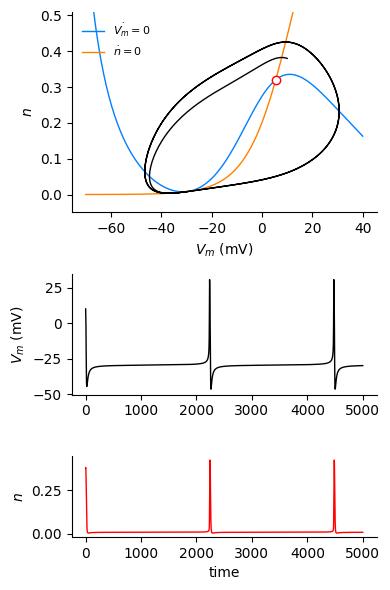

In [6]:
fig,ax = plt.subplots(3, 1, figsize=(4,6), height_ratios=(2.5,1.5,1))
ax[0].plot(V, V_null, color=[0,.5,1], lw=1, label=r'$\dot{V_m}=0$')
ax[0].plot(V, n_null, color=[1,.5,0], lw=1, label=r'$\dot{n}=0$')
ax[0].plot(sol.y[0], sol.y[1], 'k', lw=1)
for i,eq in enumerate(equil):
    col = 'g' if stable[i] else 'r'
    ax[0].plot(eq[0], eq[1], col+'o', markersize=6, markerfacecolor='w', markeredgewidth=1)
ax[0].legend(loc='best', frameon=False, fontsize=8)
ax[0].set_ylim(ylim)
ax[0].set_xlabel(r'$V_m$ (mV)')
ax[0].set_ylabel(r'$n$')

ax[1].plot(sol.t, sol.y[0], 'k', lw=1)
ax[2].plot(sol.t, sol.y[1], 'r', lw=1)
ax[1].set_ylabel(r'$V_m$ (mV)')
ax[2].set_ylabel(r'$n$')
ax[2].set_xlabel('time')
fig.tight_layout()
sns.despine()

If we increase the current further, we reach a point where the model stops spiking and the equilibrium becomes stable again, as shown in the bifurcation diagram below, taken from [this paper](https://doi.org/10.1007/s11071-016-3073-x): <br/>
Huang, C., Sun, W., Zheng, Z. et al., 2017. _Hopf bifurcation control of the M–L neuron model with type I_. Nonlinear Dyn, 87, pp.755–766.

<img src="ML_bifurcation_diagram.png"/>

The parameters used here are the same as before, except for the value of $E_K$, which they set to $-84\,\mathrm{mV}$ instead of $-80\,\mathrm{mV}$, but that doesn't qualitatively change the bifurcation diagram.

### Exercise

Show that for $I=102$ (and $E_K=-84\,\mathrm{mV}$), a stable limit cycle coexists with a stable equilibrium.